# A Network Tour of Data Science, EPFL 2016
# Project: Facial Emotion Recognition
students: Patryk Oleniuk, Carmen Galotta



In [2]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy.misc
import time
import collections
import os
import utils as ut
import importlib

importlib.reload(ut)

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Data Visualization
# Load the shortened raw CSV data, it contains only 300 pictures with labels
emotions_dataset_dir = 'fer2013_6000.csv'

#obtaining the number of line of the csv file
file = open(emotions_dataset_dir)
numline = len(file.readlines())
print (numline)


6000


# Load the data from *.csv file 
The format od the csv line is<br>
class{0,1,2,3,4,5,6},pix0 pix2304,DataUsage(not used)<br>
e.g.<br>
2,234 1 34 23 ..... 234 256 0,Training<br>
The picture is always 48x48 pixels, 0-255 greyscale.
# Remove crappy data
In the database there are some images thar are not good (e.g. some images are pixelated, unrelevant, from animations).
We try to filter them by looking at the maximum of the histogram. If the image is very homogenous, the maximum value of the histogram will be very high (above certain threshold)-> then we filter this image out. Of course we also remove some relevant information, but it's better for our CNN not to consider these images.

In [3]:
#Load the file in csv
ifile  = open(emotions_dataset_dir, "rt")
reader = csv.reader(ifile)

#preparing labels(Y) and images(X) data vectors
rownum = 0
num_data = numline;

#preparing arrays
emotions = np.zeros(num_data)
images = np.zeros((num_data,48,48))
strange_im = np.zeros((num_data,48,48))

# for image pre-filtering
num_strange = 0; #number of removed images
hist_threshold = 270 # images above this threshold will be removed
hist_div = 100 #parameter of the histogram

#parsing each row
for row in reader:
    #(column0) extract the emotion label
    #!!!! convert 1 and 0 together !!!!
    if( (row[0] == '0') or (row[0] == '1' ) ):
        emotions[rownum] = '0';
    else :
        emotions[rownum] = str(int(row[0])-1)

    #(column1) extract the image data, parse it and convert into 48x48 array of integers
    images[rownum] = np.asarray([int(s) for s in row[1].split(' ')]).reshape(48,48)
    
    #stretching contrast of the image
    images[rownum] = ut.contrast_stretch(images[rownum])
    
    #calculating the histogram and erasing "strange" images
    y_h, x_h = np.histogram( images[ rownum ] , 100 );
    if y_h.max() > hist_threshold  : 
        # if img is 'strange'
        strange_im[num_strange,:,:] = images[rownum,:,:]
        num_data = num_data - 1;
        images = np.delete(images, rownum, axis = 0);
        emotions = np.delete(emotions, rownum)
        #print('deleted:' + str(rownum))
        num_strange += 1;   
    else:
        rownum += 1
    if not rownum%200:
        print("loaded %2.0f" % ((float(rownum ) /num_data)*100) 
              + '% of dataset('+ str(rownum+num_strange)+'/'+ str(numline) + '). Filtered images: ' + str(num_strange) )
ifile.close()

print(str( len(images) ) + ' are left after \'strange images\' removal.')
print('Deleted ' + str( num_strange ) + ' strange images. Images are shown below')

# showing strange images
#for i in range(0,int(num_strange)):
#    plt.subplot( int(np.ceil(num_strange/5)),5,  i+1)
#    plt.imshow(strange_im[i])
#    y_h, x_h = np.histogram( strange_im[i,:,:] ,hist_div);
#    strange_im.sort(axis=0, )
#    plt.axis('off')
#    plt.title('max(hist) = ' + str(y_h.max()))

loaded  3% of dataset(227/6000). Filtered images: 27
loaded  7% of dataset(442/6000). Filtered images: 42
loaded 10% of dataset(657/6000). Filtered images: 57
loaded 13% of dataset(873/6000). Filtered images: 73
loaded 17% of dataset(1090/6000). Filtered images: 90
loaded 20% of dataset(1304/6000). Filtered images: 104
loaded 24% of dataset(1515/6000). Filtered images: 115
loaded 27% of dataset(1733/6000). Filtered images: 133
loaded 31% of dataset(1942/6000). Filtered images: 142
loaded 34% of dataset(2153/6000). Filtered images: 153
loaded 38% of dataset(2375/6000). Filtered images: 175
loaded 41% of dataset(2596/6000). Filtered images: 196
loaded 45% of dataset(2817/6000). Filtered images: 217
loaded 49% of dataset(3033/6000). Filtered images: 233
loaded 52% of dataset(3248/6000). Filtered images: 248
loaded 56% of dataset(3476/6000). Filtered images: 276
loaded 60% of dataset(3691/6000). Filtered images: 291
loaded 63% of dataset(3908/6000). Filtered images: 308
loaded 67% of datas

# Explore the data
Plot some random pictures from each class.

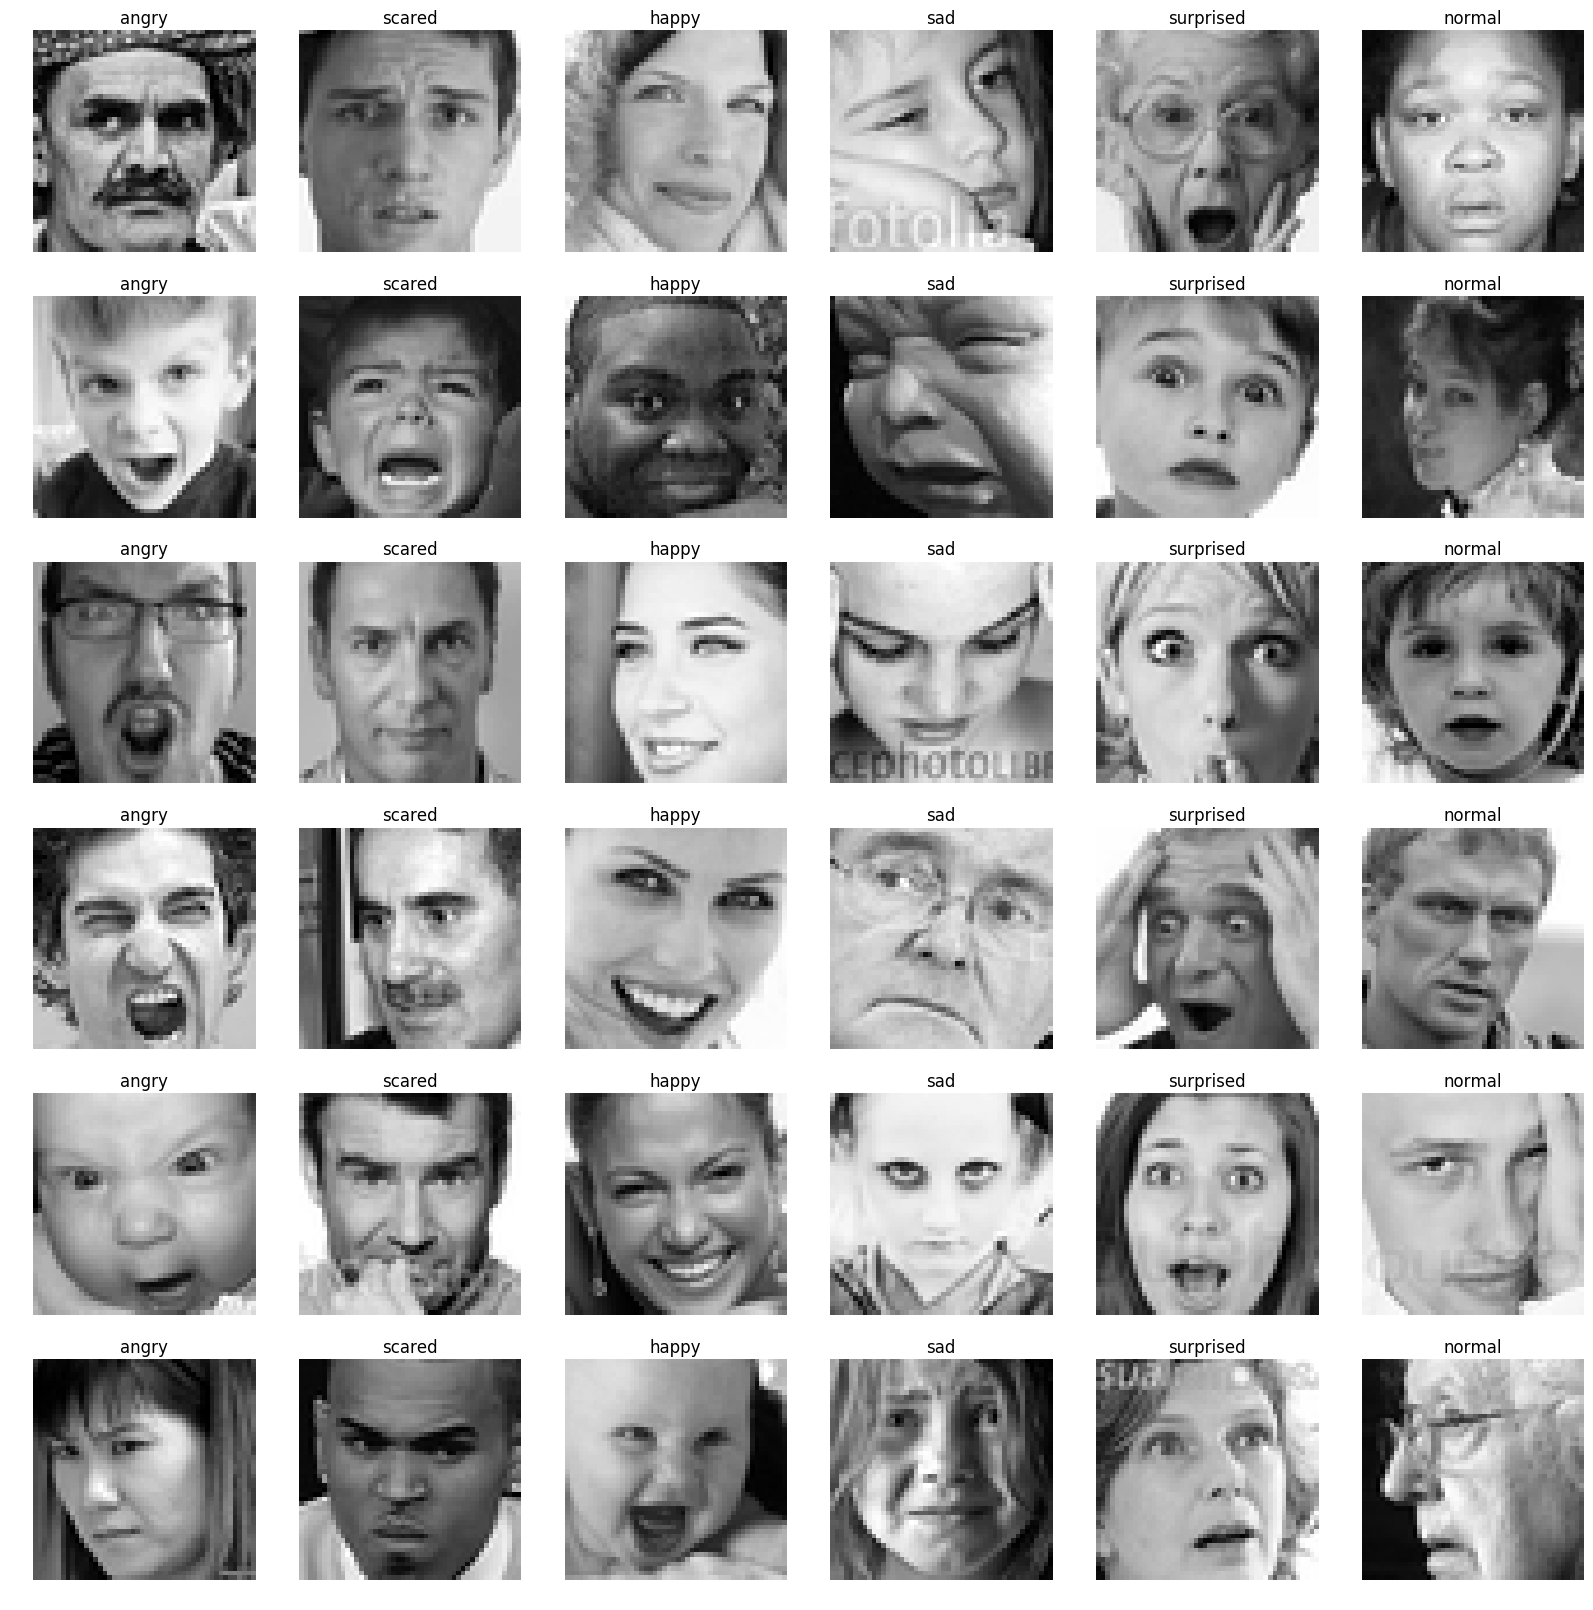

In [4]:
classes = [0,1,2,3,4,5]
str_emotions = ['angry','scared','happy','sad','surprised','normal']
num_classes = len(classes)
samples_per_class = 6
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(emotions == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx])
        y_h, x_h = np.histogram( images[idx], hist_div );
        plt.axis('off')
        plt.title(str_emotions[y] )
plt.show()

# Prepare the Data for CNN
create train and test data

In [5]:
print('number of clean data:' + str(images.shape[0]) + '  48x48 pix , 0-255 greyscale images')
n_all = images.shape[0];
n_train = 111; # number of data for training and for batch

# dividing the input data
train_data_orig = images[0:n_all-n_train,:,:]
train_labels = emotions[0:n_all-n_train]
test_data_orig = images[n_all-n_train:n_all,:,:]
test_labels = emotions[n_all-n_train:n_all]

print('orig train data ' + str(train_data_orig.shape))
print('orig train labels ' + str(train_labels.shape) + 'from ' + str(train_labels.min()) + ' to ' + str(train_labels.max()) )
print('orig test data ' + str(test_data_orig.shape))
print('orig test labels ' + str(test_labels.shape)+ 'from ' + str(test_labels.min()) + ' to ' + str(test_labels.max()) )
print('TRAIN: number of 0 labels',len(train_labels[train_labels == 0]))
print('TRAIN: number of 1 labels',len(train_labels[train_labels == 1]))
print('TRAIN: number of 2 labels',len(train_labels[train_labels == 2]))
print('TRAIN: number of 3 labels',len(train_labels[train_labels == 3]))
print('TRAIN: number of 4 labels',len(train_labels[train_labels == 4]))
print('TRAIN: number of 5 labels',len(train_labels[train_labels == 5]))
print('TEST: number of 0 labels',len(test_labels[test_labels == 0]))
print('TEST: number of 1 labels',len(test_labels[test_labels == 1]))
print('TEST: number of 2 labels',len(test_labels[test_labels == 2]))
print('TEST: number of 3 labels',len(test_labels[test_labels == 3]))
print('TEST: number of 4 labels',len(test_labels[test_labels == 4]))
print('TEST: number of 5 labels',len(test_labels[test_labels== 5]))
#plt.imshow(train_data_orig[0,:,:])

number of clean data:5506  48x48 pix , 0-255 greyscale images
orig train data (5395, 48, 48)
orig train labels (5395,)from 0.0 to 5.0
orig test data (111, 48, 48)
orig test labels (111,)from 0.0 to 5.0
TRAIN: number of 0 labels 845
TRAIN: number of 1 labels 774
TRAIN: number of 2 labels 1417
TRAIN: number of 3 labels 884
TRAIN: number of 4 labels 547
TRAIN: number of 5 labels 928
TEST: number of 0 labels 17
TEST: number of 1 labels 13
TEST: number of 2 labels 24
TEST: number of 3 labels 22
TEST: number of 4 labels 11
TEST: number of 5 labels 24


# Convert, normalize, subtract the const mean value from the data


In [6]:
# Data pre-processing
n = train_data_orig.shape[0];
train_data = np.zeros([n,48**2])
for i in range(n):
    xx = train_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    train_data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])

n = test_data_orig.shape[0]
test_data = np.zeros([n,48**2])
for i in range(n):
    xx = test_data_orig[i,:,:]
    xx -= np.mean(xx)
    xx /= np.linalg.norm(xx)
    test_data[i] = np.reshape(xx,[-1])

print(train_data.shape)
print(test_data.shape)
print(train_data_orig[0][2][2])
print(test_data[0][2])
#plt.imshow(train_data[0].reshape([48,48]))

(5395, 2304)
(111, 2304)
-0.0261129868292
-0.0373232126829


In [7]:
# Convert label values to one_hot vector

train_labels = ut.convert_to_one_hot(train_labels,num_classes)
test_labels = ut.convert_to_one_hot(test_labels,num_classes)

print(train_labels.shape)
print(test_labels.shape)

(5395, 6)
(111, 6)


# Model 

Define a convolutional neural network classifier:

$$
y=\textrm{softmax}(ReLU( x \ast W_1+b_1)W_2+b_2) 
$$
with/out dropout regularization

In [8]:
# Define computational graph (CG)
batch_size = n_train    # batch size
d = train_data.shape[1]  # data dimensionality
nc = 6                  # number of classes

# CG inputs
xin = tf.placeholder(tf.float32,[batch_size,d]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size,nc]); #print('y_label=',y_label,y_label.get_shape())
d = tf.placeholder(tf.float32);

# Convolutional layer
K0 = 10   # size of the patch
F0 = 64  # number of filters
ncl0 = K0*K0*F0
Wcl0 = tf.Variable(tf.truncated_normal([K0,K0,1,F0], stddev=tf.sqrt(2./tf.to_float(ncl0)) )); print('Wcl=',Wcl0.get_shape())
bcl0 = tf.Variable(tf.zeros([F0])); print('bcl=',bcl0.get_shape())
x_2d0 = tf.reshape(xin, [-1,48,48,1]); print('x_2d=',x_2d0.get_shape())
x = tf.nn.conv2d(x_2d0, Wcl0, strides=[1, 1, 1, 1], padding='SAME')
x += bcl0; print('x2=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Dropout
# x = tf.nn.dropout(x, d)

# Fully Connected layer
nfc = 48*48*F0
x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,nc], stddev=tf.sqrt(2./tf.to_float(nfc+nc)) )); print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([nc])); print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
y += bfc; print('y2=',y.get_shape())

# Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
total_loss = cross_entropy

# Optimization scheme
#train_step = tf.train.GradientDescentOptimizer(0.02).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Wcl= (10, 10, 1, 64)
bcl= (64,)
x_2d= (111, 48, 48, 1)
x2= (111, 48, 48, 64)
x3= (111, 147456)
Wfc= (147456, 6)
bfc= (6,)
y1= (111, 6)
y2= (111, 6)
y3(SOFTMAX)= (111, 6)


# Runing the computational graph

In [10]:
# Run Computational Graph
n = train_data.shape[0]
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(1001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x, batch_y = train_data[idx,:], train_labels[idx]
    #print(batch_x.shape,batch_y.shape)
    
    # Run CG for variable training
    _,acc_train,total_loss_o = sess.run([train_step,accuracy,total_loss], feed_dict={xin: batch_x, y_label: batch_y})
    
    # Run CG for test set
    if not i%50:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)


Iteration i= 0 , train accuracy= 0.189189 , loss= 1.79192
test accuracy= 0.225225

Iteration i= 50 , train accuracy= 0.378378 , loss= 1.58919
test accuracy= 0.333333

Iteration i= 100 , train accuracy= 0.378378 , loss= 1.51033
test accuracy= 0.342342

Iteration i= 150 , train accuracy= 0.477477 , loss= 1.37115
test accuracy= 0.351351

Iteration i= 200 , train accuracy= 0.621622 , loss= 1.14798
test accuracy= 0.306306

Iteration i= 250 , train accuracy= 0.495495 , loss= 1.27861
test accuracy= 0.342342

Iteration i= 300 , train accuracy= 0.558559 , loss= 1.25862
test accuracy= 0.324324

Iteration i= 350 , train accuracy= 0.576577 , loss= 1.1213
test accuracy= 0.333333

Iteration i= 400 , train accuracy= 0.585586 , loss= 0.968241
test accuracy= 0.306306

Iteration i= 450 , train accuracy= 0.702703 , loss= 0.88415
test accuracy= 0.315315

Iteration i= 500 , train accuracy= 0.72973 , loss= 0.717995
test accuracy= 0.324324

Iteration i= 550 , train accuracy= 0.720721 , loss= 0.775543
test a

# Feeding the  CNN with some data (camera/file)

normal


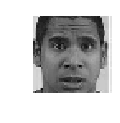

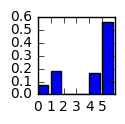

scared


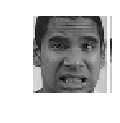

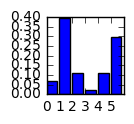

scared


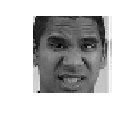

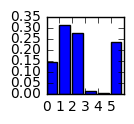

surprised


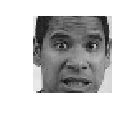

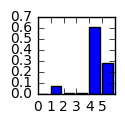

sad


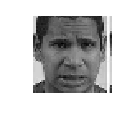

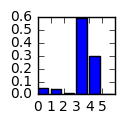

normal


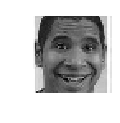

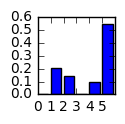

normal


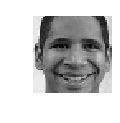

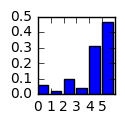

happy


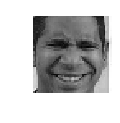

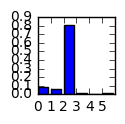

normal


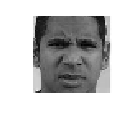

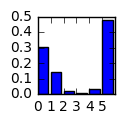

normal


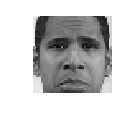

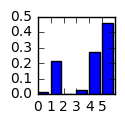

In [138]:
import PIL
from IPython.display import clear_output

clear_output()
plt.rcParams['figure.figsize'] = (1.0, 1.0) # set default size of plots
#plot = plt.imshow(strange_im[0])
cntr = 0;

faces, marked_img = ut.get_faces_from_img('diff_emotions.jpg');
# if some face was found in the camera image
if(len(faces)):      
    #creating the blank test vector
    data_orig = np.zeros([n_train, 48,48])

    #putting face data into the vector (only first few)
    for i in range(0, len(faces)):
        data_orig[i,:,:] = ut.contrast_stretch(faces[i,:,:]);

        #preparing image and putting it into the batch
        n = data_orig.shape[0];
        data = np.zeros([n,48**2])
        for i in range(n):
            xx = data_orig[i,:,:]
            xx -= np.mean(xx)
            xx /= np.linalg.norm(xx)
            data[i,:] = xx.reshape(2304); #np.reshape(xx,[-1])

    result = sess.run([y], feed_dict={xin: data, d: 1.0})
    
    for i in range(0, len(faces)):
        emotion_nr = np.argmax(result[0][i]);
        print(str_emotions[emotion_nr])
        plt.subplots()
        plt.imshow(np.reshape(data[i,:], (48,48)))
        plt.axis('off')
        fig, ax = plt.subplots()
        ax.bar(np.arange(nc) , result[0][i])
        ax.set_xticklabels(('0', '1', '2', '3','4','5' ))
        plt.show()
    